#日本語対応

In [ ]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

#import

In [ ]:
from itertools import product

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
import lightgbm as lgb

#データ読み込み

In [ ]:
sales = pd.read_csv('sales_history.csv')
cats = pd.read_csv('item_categories.csv')
cat_names = pd.read_csv('category_names.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv', header=None)

#各データの表示

sales_historyに関する情報

In [ ]:
print(sales.info())
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119570 entries, 0 to 1119569
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   日付      1119570 non-null  object 
 1   店舗ID    1119570 non-null  int64  
 2   商品ID    1119570 non-null  int64  
 3   商品価格    1119570 non-null  int64  
 4   売上個数    1119570 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 42.7+ MB
None


,日付,店舗ID,商品ID,商品価格,売上個数
0,2018-01-01,9,1000001,420,1.0
1,2018-01-01,6,1000001,420,1.0
2,2018-01-01,10,1000001,420,1.0
3,2018-01-01,0,1000017,250,1.0
4,2018-01-01,1,1000017,250,1.0


item_category

In [ ]:
print(cats.info())
cats.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9426 entries, 0 to 9425
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   商品ID      9426 non-null   int64
 1   商品カテゴリID  9426 non-null   int64
dtypes: int64(2)
memory usage: 147.4 KB
None


,商品ID,商品カテゴリID
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100


category_names

In [ ]:
print(cat_names.info())
cat_names.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   商品カテゴリID  26 non-null     int64 
 1   商品カテゴリ名   26 non-null     object
dtypes: int64(1), object(1)
memory usage: 544.0+ bytes
None


,商品カテゴリID,商品カテゴリ名
0,100,映画 - DVD
1,110,PCゲーム - 通常版
2,120,音楽 - その他
3,130,ゲーム - ゲーム機C
4,140,映画 - ブルーレイ


testデータの表示

In [ ]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   index   3060 non-null   int64
 1   商品ID    3060 non-null   int64
 2   店舗ID    3060 non-null   int64
dtypes: int64(3)
memory usage: 71.8 KB
None


,index,商品ID,店舗ID
0,0,1000001,0
1,1,1000001,1
2,2,1000001,2
3,3,1000001,3
4,4,1000001,4


sample_submissionに関する情報

In [ ]:
print(cats.info())
cats.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9426 entries, 0 to 9425
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   商品ID      9426 non-null   int64
 1   商品カテゴリID  9426 non-null   int64
dtypes: int64(2)
memory usage: 147.4 KB
None


,商品ID,商品カテゴリID
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100


In [ ]:
cats

,商品ID,商品カテゴリID
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100
...,...,...
9421,3500072,350
9422,3500073,350
9423,3500074,350
9424,3500075,350


trainデータ、testデータに含まれる商品IDの種類数


In [ ]:
print("train：",sales['商品ID'].nunique())
print("test：",test['商品ID'].nunique())

train： 9040
test： 170


#データの統合(マージ)
「sales_historiy」,「item_category」,「category_names」の3つを統合

In [ ]:
merged_data = pd.merge(sales,cats,on='商品ID',how='left')
merged_data = pd.merge(merged_data,cat_names,on='商品カテゴリID',how='left')
merged_data['大カテゴリ名'] = merged_data['商品カテゴリ名'].str.split(pat = '-',n = 2,expand=True)[0]
merged_data['小カテゴリ名'] = merged_data['商品カテゴリ名'].str.split(pat = '-',n = 2,expand=True)[1]

merged_data.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,大カテゴリ名,小カテゴリ名
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD,映画,DVD
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD,映画,DVD
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD,映画,DVD
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD,映画,DVD
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD,映画,DVD


In [ ]:
cats_s = merged_data.groupby(['商品カテゴリID','大カテゴリ名','小カテゴリ名']).count().reset_index()[['商品カテゴリID','大カテゴリ名','小カテゴリ名']]

In [ ]:
cats_s

,商品カテゴリID,大カテゴリ名,小カテゴリ名
0,100,映画,DVD
1,110,PCゲーム,通常版
2,120,音楽,その他
3,130,ゲーム,ゲーム機C
4,140,映画,ブルーレイ
5,150,ゲーム,ゲーム機B
6,160,ギフト,小型ゲーム
7,170,ギフト,カード、パズル等
8,180,ギフト,フィギュア
9,190,PCソフト,PCソフト


In [ ]:
from sklearn.preprocessing import LabelEncoder
cats_s['big_code'] = LabelEncoder().fit_transform(cats_s['大カテゴリ名'])
cats_s['sub_code'] = LabelEncoder().fit_transform(cats_s['小カテゴリ名'])
cats_s

,商品カテゴリID,大カテゴリ名,小カテゴリ名,big_code,sub_code
0,100,映画,DVD,5,1
1,110,PCゲーム,通常版,0,23
2,120,音楽,その他,7,3
3,130,ゲーム,ゲーム機C,3,11
4,140,映画,ブルーレイ,5,14
5,150,ゲーム,ゲーム機B,3,10
6,160,ギフト,小型ゲーム,2,19
7,170,ギフト,カード、パズル等,2,7
8,180,ギフト,フィギュア,2,13
9,190,PCソフト,PCソフト,1,2


統合したデータを扱いやすい形にする。
#日付カラムから、「年」、「月」の情報を抽出

In [ ]:
sales['年'] = sales['日付'].apply(lambda x: x.split('-')[0])
sales['月'] = sales['日付'].apply(lambda x: x.split('-')[1])
sales['日'] = sales['日付'].apply(lambda x: x.split('-')[2])

sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,年,月,日
0,2018-01-01,9,1000001,420,1.0,2018,01,01
1,2018-01-01,6,1000001,420,1.0,2018,01,01
2,2018-01-01,10,1000001,420,1.0,2018,01,01
3,2018-01-01,0,1000017,250,1.0,2018,01,01
4,2018-01-01,1,1000017,250,1.0,2018,01,01


In [ ]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119570 entries, 0 to 1119569
Data columns (total 8 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   日付      1119570 non-null  object 
 1   店舗ID    1119570 non-null  int64  
 2   商品ID    1119570 non-null  int64  
 3   商品価格    1119570 non-null  int64  
 4   売上個数    1119570 non-null  float64
 5   年       1119570 non-null  object 
 6   月       1119570 non-null  object 
 7   日       1119570 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 68.3+ MB
None


#「年」と「月」の全組み合わせを作成する

In [ ]:
gp_time =sales.groupby(['年','月']).count().reset_index()[['年','月']]
gp_time

,年,月
0,2018,01
1,2018,02
2,2018,03
3,2018,04
4,2018,05
5,2018,06
6,2018,07
7,2018,08
8,2018,09
9,2018,10


上記のデータに「月」単位で通し番号をつける

#カラム名「月ブロック」を追加、通し番号をつける

In [ ]:
gp_time['月ブロック'] = list(range(len(gp_time)))

#test用データに、評価対象期間である2019年12月のレコードを追加する

In [ ]:
gp_time = gp_time.append({
    '月ブロック':23,
    '年':'2019',
    '月':'12'
},ignore_index=True)

gp_time

,年,月,月ブロック
0,2018,01,0
1,2018,02,1
2,2018,03,2
3,2018,04,3
4,2018,05,4
5,2018,06,5
6,2018,07,6
7,2018,08,7
8,2018,09,8
9,2018,10,9


#「月ブロック」をsalesに統合

In [ ]:
sales = pd.merge(sales,gp_time,on=['年','月'],how='left')
sales

,日付,店舗ID,商品ID,商品価格,売上個数,年,月,日,月ブロック
0,2018-01-01,9,1000001,420,1.0,2018,01,01,0
1,2018-01-01,6,1000001,420,1.0,2018,01,01,0
2,2018-01-01,10,1000001,420,1.0,2018,01,01,0
3,2018-01-01,0,1000017,250,1.0,2018,01,01,0
4,2018-01-01,1,1000017,250,1.0,2018,01,01,0
...,...,...,...,...,...,...,...,...,...
1119565,2019-10-31,8,3400006,2700,1.0,2019,10,31,21
1119566,2019-10-31,7,3400009,1020,1.0,2019,10,31,21
1119567,2019-10-31,7,3400012,510,1.0,2019,10,31,21
1119568,2019-10-31,4,3500001,340,1.0,2019,10,31,21


#月単位ごとの売上個数を集計

In [ ]:
sales_month = sales.groupby('月ブロック').agg({'売上個数':np.sum}).reset_index()
sales_month.head()

,月ブロック,売上個数
0,0,69027.0
1,1,67740.0
2,2,77767.0
3,3,55991.0
4,4,53425.0


<BarContainer object of 22 artists>

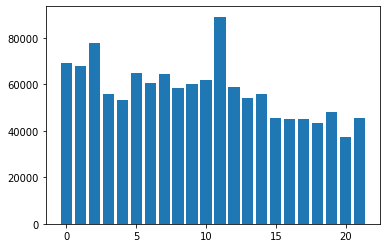

In [ ]:
plt.bar(sales_month['月ブロック'],sales_month['売上個数'])

上記のグラフより、2018の12 月の売り上げが多い傾向

#「月ブロック」「商品ID」「店舗ID」でグルーピングし、売上個数の合計をとる

In [ ]:
gp_month = sales.groupby(['月ブロック','商品ID','店舗ID']).agg({'売上個数':np.sum}).reset_index()
gp_month

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.0
1,0,1000001,1,2.0
2,0,1000001,2,1.0
3,0,1000001,3,2.0
4,0,1000001,5,2.0
...,...,...,...,...
495129,21,3500070,16,1.0
495130,21,3500071,13,1.0
495131,21,3500072,2,1.0
495132,21,3500072,16,1.0


In [ ]:
gp_revenue

,月ブロック,商品ID,店舗ID,収益
0,0,1000001,0,2520.0
1,0,1000001,1,650.0
2,0,1000001,2,420.0
3,0,1000001,3,840.0
4,0,1000001,5,760.0
...,...,...,...,...
495129,21,3500070,16,420.0
495130,21,3500071,13,590.0
495131,21,3500072,2,420.0
495132,21,3500072,16,420.0


salesデータには、売上個数が0となる場合のデータが含まれていない
#「月」×「商品ID」×「店舗ID」の組み合わせを作りつつ、売上個数が0個となる場合も含めたデータの生成

In [ ]:
all_combination=[]
columns = ['月ブロック','商品ID','店舗ID']

for i in range(22):
  train_block = sales[sales['月ブロック']==i]
  all_combination.append(np.array(list(product([i],train_block['商品ID'].unique(),train_block['店舗ID'].unique()))))

all_combination = pd.DataFrame(np.vstack(all_combination),columns=columns)
all_combination.sort_values(columns,inplace=True)

print(all_combination.info())
all_combination

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648926 entries, 3 to 1644693
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   月ブロック   1648926 non-null  int64
 1   商品ID    1648926 non-null  int64
 2   店舗ID    1648926 non-null  int64
dtypes: int64(3)
memory usage: 50.3 MB
None


,月ブロック,商品ID,店舗ID
3,0,1000001,0
4,0,1000001,1
7,0,1000001,2
15,0,1000001,3
16,0,1000001,4
...,...,...,...
1644680,21,3500073,13
1644694,21,3500073,14
1644679,21,3500073,15
1644685,21,3500073,16


売上履歴データの追加

In [ ]:
all_train = pd.merge(all_combination,gp_month,on=['月ブロック','商品ID','店舗ID'],how='left')

In [ ]:
all_train.isna().sum()

月ブロック          0
商品ID           0
店舗ID           0
売上個数     1153792
収益       1153792
商品価格           0
dtype: int64

In [ ]:
all_train

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.0
1,0,1000001,1,2.0
2,0,1000001,2,1.0
3,0,1000001,3,2.0
4,0,1000001,4,NaN
...,...,...,...,...
1648921,21,3500073,13,NaN
1648922,21,3500073,14,NaN
1648923,21,3500073,15,NaN
1648924,21,3500073,16,NaN


売上個数がNaNとなっている箇所は、売上個数0個として値を埋める

In [ ]:
all_train['売上個数'] = all_train['売上個数'].fillna(0)

In [ ]:
all_train

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.0
1,0,1000001,1,2.0
2,0,1000001,2,1.0
3,0,1000001,3,2.0
4,0,1000001,4,0.0
...,...,...,...,...
1648921,21,3500073,13,0.0
1648922,21,3500073,14,0.0
1648923,21,3500073,15,0.0
1648924,21,3500073,16,0.0


In [ ]:
all_train.drop(labels='商品価格',axis=1)

,月ブロック,商品ID,店舗ID,売上個数,収益
0,0,1000001,0,6.0,2520.0
1,0,1000001,1,2.0,650.0
2,0,1000001,2,1.0,420.0
3,0,1000001,3,2.0,840.0
4,0,1000001,4,-1.0,-420.0
...,...,...,...,...,...
1648921,21,3500073,13,-1.0,-420.0
1648922,21,3500073,14,-1.0,-420.0
1648923,21,3500073,15,-1.0,-420.0
1648924,21,3500073,16,-1.0,-420.0


#testデータにカラムを追加

In [ ]:
new_test = test.copy()

評価対象期間が2019年12(月ブロック：23)であるという情報の追加

In [ ]:
new_test['月ブロック'] = 23

In [ ]:
new_test.head()

,index,商品ID,店舗ID,月ブロック
0,0,1000001,0,23
1,1,1000001,1,23
2,2,1000001,2,23
3,3,1000001,3,23
4,4,1000001,4,23


##学習データとテストデータを縦に統合

In [ ]:
dataset = pd.concat([all_train,new_test])
dataset

,月ブロック,商品ID,店舗ID,売上個数,index
0,0,1000001,0,6.0,NaN
1,0,1000001,1,2.0,NaN
2,0,1000001,2,1.0,NaN
3,0,1000001,3,2.0,NaN
4,0,1000001,4,0.0,NaN
...,...,...,...,...,...
3055,23,3500001,13,NaN,3055.0
3056,23,3500001,14,NaN,3056.0
3057,23,3500001,15,NaN,3057.0
3058,23,3500001,16,NaN,3058.0


In [ ]:
dataset

,月ブロック,商品ID,店舗ID,売上個数,index
0,0,1000001,0,6.0,NaN
1,0,1000001,1,2.0,NaN
2,0,1000001,2,1.0,NaN
3,0,1000001,3,2.0,NaN
4,0,1000001,4,0.0,NaN
...,...,...,...,...,...
3055,23,3500001,13,NaN,3055.0
3056,23,3500001,14,NaN,3056.0
3057,23,3500001,15,NaN,3057.0
3058,23,3500001,16,NaN,3058.0


#特徴量の作成

In [ ]:
#昨年度同月の売上個数が今年度の売上個数の予測に役立つのではないかという仮説のもとに、ラグ特徴量を生成する
#ここでは、月ブロックを1年分(12)ずらした上でデータを統合するという方法を取る。

In [ ]:
lag = dataset.copy()

In [ ]:
lag['月ブロック'] = lag['月ブロック']+12
lag = lag.rename(columns={'売上個数':'12か月前の売上個数'})
lag

,月ブロック,商品ID,店舗ID,12か月前の売上個数,index
0,12,1000001,0,6.0,NaN
1,12,1000001,1,2.0,NaN
2,12,1000001,2,1.0,NaN
3,12,1000001,3,2.0,NaN
4,12,1000001,4,0.0,NaN
...,...,...,...,...,...
3055,35,3500001,13,NaN,3055.0
3056,35,3500001,14,NaN,3056.0
3057,35,3500001,15,NaN,3057.0
3058,35,3500001,16,NaN,3058.0


In [ ]:
#ラグ特徴量の追加

In [ ]:
dataset2 = pd.merge(dataset,lag,on=['月ブロック','商品ID','店舗ID'],how='left',left_index=True)
print(dataset2.groupby('月ブロック').agg({'12か月前の売上個数':'count'}))

       12か月前の売上個数
月ブロック            
0               0
1               0
2               0
3               0
4               0
5               0
6               0
7               0
8               0
9               0
10              0
11              0
12          42354
13          40356
14          40122
15          37296
16          36216
17          36774
18          37746
19          35406
20          31392
21          32508
23           2700


In [ ]:
#「商品カテゴリ」「年・月」情報の追加

In [ ]:
dataset3 = pd.merge(dataset2,cats,on='商品ID',how='left')
dataset3 = pd.merge(dataset3,gp_time,on='月ブロック',how='left')

print(dataset3.info())
dataset3.head()

In [ ]:
#文字データを数値データに直す
dataset3['年'] = dataset3['年'].astype(int)
dataset3['月'] = dataset3['月'].astype(int)

In [ ]:
#欠損値を0で埋める
dataset3 = dataset3.fillna(0)
dataset3 = dataset3.drop(labels=['index_x','index_y'],axis=1)
dataset3.head()

,月ブロック,商品ID,店舗ID,売上個数,12か月前の売上個数,商品カテゴリID,年,月
0,0,1000001,0,6.0,0.0,100,2018,1
1,0,1000001,1,2.0,0.0,100,2018,1
2,0,1000001,2,1.0,0.0,100,2018,1
3,0,1000001,3,2.0,0.0,100,2018,1
4,0,1000001,4,0.0,0.0,100,2018,1


In [ ]:
dataset3

,月ブロック,商品ID,店舗ID,売上個数,収益_x,商品価格_x,12か月前の売上個数,商品カテゴリID,年,月,商品価格
0,0,1000001,0,6.0,2520.0,420.0,-1.0,100,2018,1,420.0
1,0,1000001,1,2.0,650.0,420.0,-1.0,100,2018,1,420.0
2,0,1000001,2,1.0,420.0,420.0,-1.0,100,2018,1,420.0
3,0,1000001,3,2.0,840.0,420.0,-1.0,100,2018,1,420.0
4,0,1000001,4,-1.0,-420.0,420.0,-1.0,100,2018,1,420.0
...,...,...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,-1.0,NaN,NaN,3.0,350,2019,12,420.0
1651982,23,3500001,14,-1.0,NaN,NaN,-1.0,350,2019,12,420.0
1651983,23,3500001,15,-1.0,NaN,NaN,-1.0,350,2019,12,420.0
1651984,23,3500001,16,-1.0,NaN,NaN,-1.0,350,2019,12,420.0


In [ ]:
dataset3 = pd.merge(dataset3,cats_s,on='商品カテゴリID',how='left')
dataset3

,月ブロック,商品ID,店舗ID,売上個数,12か月前の売上個数,商品カテゴリID,年,月,大カテゴリ名,小カテゴリ名,big_code,sub_code
0,0,1000001,0,6.0,0.0,100,2018,1,映画,DVD,5,1
1,0,1000001,1,2.0,0.0,100,2018,1,映画,DVD,5,1
2,0,1000001,2,1.0,0.0,100,2018,1,映画,DVD,5,1
3,0,1000001,3,2.0,0.0,100,2018,1,映画,DVD,5,1
4,0,1000001,4,0.0,0.0,100,2018,1,映画,DVD,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,0.0,3.0,350,2019,12,本,オーディオブック_タイプB,6,6
1651982,23,3500001,14,0.0,0.0,350,2019,12,本,オーディオブック_タイプB,6,6
1651983,23,3500001,15,0.0,0.0,350,2019,12,本,オーディオブック_タイプB,6,6
1651984,23,3500001,16,0.0,0.0,350,2019,12,本,オーディオブック_タイプB,6,6


In [ ]:
dataset3 = dataset3.drop(['大カテゴリ名','小カテゴリ名'],axis=1)

In [ ]:
print(dataset3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651986 entries, 0 to 1651985
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   月ブロック       1651986 non-null  int64  
 1   商品ID        1651986 non-null  int64  
 2   店舗ID        1651986 non-null  int64  
 3   売上個数        1651986 non-null  float64
 4   12か月前の売上個数  1651986 non-null  float64
 5   商品カテゴリID    1651986 non-null  int64  
 6   年           1651986 non-null  int64  
 7   月           1651986 non-null  int64  
 8   big_code    1651986 non-null  int64  
 9   sub_code    1651986 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 138.6 MB
None


In [ ]:
dataset3

,月ブロック,商品ID,店舗ID,売上個数,12か月前の売上個数,商品カテゴリID,年,月,big_code,sub_code
0,0,1000001,0,6.0,0.0,100,2018,1,5,1
1,0,1000001,1,2.0,0.0,100,2018,1,5,1
2,0,1000001,2,1.0,0.0,100,2018,1,5,1
3,0,1000001,3,2.0,0.0,100,2018,1,5,1
4,0,1000001,4,0.0,0.0,100,2018,1,5,1
...,...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,0.0,3.0,350,2019,12,6,6
1651982,23,3500001,14,0.0,0.0,350,2019,12,6,6
1651983,23,3500001,15,0.0,0.0,350,2019,12,6,6
1651984,23,3500001,16,0.0,0.0,350,2019,12,6,6


#店舗規模の作成

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sales['売り上げ']=sales['商品価格'] * sales['売上個数']
df_uriage = sales[['店舗ID','売り上げ']]
df_uriage2 = df_uriage.groupby(['店舗ID']).sum()
#正規化のクラスを準備
ms = MinMaxScaler()
#特徴量の最大値と最小値を計算し変換
data_sc = ms.fit_transform(df_uriage2)
df_uriage2['店舗規模'] = data_sc
df_uriage2 = df_uriage2.reset_index()
df_uriage3 = df_uriage2[['店舗ID','店舗規模']]
dataset3 = pd.merge(dataset3, df_uriage3,left_on=['店舗ID'], right_on=['店舗ID'], how='left')

In [ ]:
dataset3

,月ブロック,商品ID,店舗ID,売上個数,12か月前の売上個数,商品カテゴリID,年,月,big_code,sub_code,店舗規模
0,0,1000001,0,6.0,0.0,100,2018,1,5,1,0.759107
1,0,1000001,1,2.0,0.0,100,2018,1,5,1,0.053980
2,0,1000001,2,1.0,0.0,100,2018,1,5,1,0.227012
3,0,1000001,3,2.0,0.0,100,2018,1,5,1,0.459860
4,0,1000001,4,0.0,0.0,100,2018,1,5,1,0.277599
...,...,...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,0.0,3.0,350,2019,12,6,6,0.744480
1651982,23,3500001,14,0.0,0.0,350,2019,12,6,6,0.178923
1651983,23,3500001,15,0.0,0.0,350,2019,12,6,6,0.008620
1651984,23,3500001,16,0.0,0.0,350,2019,12,6,6,0.000000


#周期性　三角関数化

In [ ]:
def encode(df, column):
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / df[column].max())
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / df[column].max())
    return df

# def enc_day():
#     global dataset3
#     dataset3['日'] = encode(dataset3, '日')

# def enc_year():
#     global dataset3
#     dataset3['年'] = encode(dataset3, '年')

def enc_month():
    global dataset3
    global df
    dataset3 = encode(dataset3, '月')

In [ ]:
#三角関数化実行
enc_month()
dataset3

,月ブロック,商品ID,店舗ID,売上個数,12か月前の売上個数,商品カテゴリID,年,月,big_code,sub_code,店舗規模,月_cos,月_sin
0,0,1000001,0,6.0,0.0,100,2018,1,5,1,0.759107,0.866025,5.000000e-01
1,0,1000001,1,2.0,0.0,100,2018,1,5,1,0.053980,0.866025,5.000000e-01
2,0,1000001,2,1.0,0.0,100,2018,1,5,1,0.227012,0.866025,5.000000e-01
3,0,1000001,3,2.0,0.0,100,2018,1,5,1,0.459860,0.866025,5.000000e-01
4,0,1000001,4,0.0,0.0,100,2018,1,5,1,0.277599,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,0.0,3.0,350,2019,12,6,6,0.744480,1.000000,-2.449294e-16
1651982,23,3500001,14,0.0,0.0,350,2019,12,6,6,0.178923,1.000000,-2.449294e-16
1651983,23,3500001,15,0.0,0.0,350,2019,12,6,6,0.008620,1.000000,-2.449294e-16
1651984,23,3500001,16,0.0,0.0,350,2019,12,6,6,0.000000,1.000000,-2.449294e-16


In [ ]:
print(dataset3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651986 entries, 0 to 1651985
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   月ブロック       1651986 non-null  int64  
 1   商品ID        1651986 non-null  int64  
 2   店舗ID        1651986 non-null  int64  
 3   売上個数        1651986 non-null  float64
 4   12か月前の売上個数  1651986 non-null  float64
 5   商品カテゴリID    1651986 non-null  int64  
 6   年           1651986 non-null  int64  
 7   月           1651986 non-null  int64  
 8   big_code    1651986 non-null  int64  
 9   sub_code    1651986 non-null  int64  
 10  店舗規模        1651986 non-null  float64
 11  月_cos       1651986 non-null  float64
 12  月_sin       1651986 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 176.5 MB
None


#学習用データとテスト用データに分割

In [ ]:
#学習データは「12ヶ月前の売上個数」カラムが存在するもの
train_dataset = dataset3[(dataset3['月ブロック'] >= 12) & (dataset3['月ブロック'] != 23)]

test_dataset = dataset3[dataset3['月ブロック']==23]

In [ ]:
train_dataset

,月ブロック,商品ID,店舗ID,売上個数,12か月前の売上個数,商品カテゴリID,年,月,big_code,sub_code,店舗規模,月_cos,月_sin
989100,12,1000001,0,2.0,6.0,100,2019,1,5,1,0.759107,0.866025,0.500000
989101,12,1000001,1,0.0,2.0,100,2019,1,5,1,0.053980,0.866025,0.500000
989102,12,1000001,2,0.0,1.0,100,2019,1,5,1,0.227012,0.866025,0.500000
989103,12,1000001,3,5.0,2.0,100,2019,1,5,1,0.459860,0.866025,0.500000
989104,12,1000001,4,4.0,0.0,100,2019,1,5,1,0.277599,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648921,21,3500073,13,0.0,0.0,350,2019,10,6,6,0.744480,0.500000,-0.866025
1648922,21,3500073,14,0.0,0.0,350,2019,10,6,6,0.178923,0.500000,-0.866025
1648923,21,3500073,15,0.0,0.0,350,2019,10,6,6,0.008620,0.500000,-0.866025
1648924,21,3500073,16,0.0,0.0,350,2019,10,6,6,0.000000,0.500000,-0.866025


In [ ]:
test_dataset

,月ブロック,商品ID,店舗ID,売上個数,12か月前の売上個数,商品カテゴリID,年,月,big_code,sub_code,店舗規模,月_cos,月_sin
1648926,23,1000001,0,0.0,0.0,100,2019,12,5,1,0.759107,1.0,-2.449294e-16
1648927,23,1000001,1,0.0,0.0,100,2019,12,5,1,0.053980,1.0,-2.449294e-16
1648928,23,1000001,2,0.0,0.0,100,2019,12,5,1,0.227012,1.0,-2.449294e-16
1648929,23,1000001,3,0.0,9.0,100,2019,12,5,1,0.459860,1.0,-2.449294e-16
1648930,23,1000001,4,0.0,7.0,100,2019,12,5,1,0.277599,1.0,-2.449294e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,0.0,3.0,350,2019,12,6,6,0.744480,1.0,-2.449294e-16
1651982,23,3500001,14,0.0,0.0,350,2019,12,6,6,0.178923,1.0,-2.449294e-16
1651983,23,3500001,15,0.0,0.0,350,2019,12,6,6,0.008620,1.0,-2.449294e-16
1651984,23,3500001,16,0.0,0.0,350,2019,12,6,6,0.000000,1.0,-2.449294e-16


In [ ]:
dataset3.corr()[['売上個数']].style.background_gradient(cmap="bwr",vmin=-1,vmax=1,axis=None)

,売上個数
月ブロック,-0.008406
商品ID,-0.046192
店舗ID,-0.026649
売上個数,1.000000
12か月前の売上個数,0.063283
商品カテゴリID,-0.046180
年,-0.011452
月,0.004567
big_code,-0.141648
sub_code,0.091979


#XGBoost

In [ ]:
#xgb

In [ ]:
#学習データは「12ヶ月前の売上個数」カラムが存在するもの
train_dataset = dataset3[(dataset3['月ブロック'] >= 12) & (dataset3['月ブロック'] != 23)]

test_dataset = dataset3[dataset3['月ブロック']==23]

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [ ]:
df_train,df_val = train_test_split(train_dataset,test_size=0.3)

In [ ]:
X_train = df_train.drop(['売上個数','月ブロック','年','月'],axis=1)
X_valid = df_val.drop(['売上個数','月ブロック','年','月'],axis=1)
y_train = df_train['売上個数']
y_valid = df_val['売上個数']

In [ ]:
dtrain = xgb.DMatrix(X_train,label = y_train)
dvalid = xgb.DMatrix(X_valid,label =y_valid)

In [ ]:
params = {
    "objective" : "reg:squarederror",
    "eval_metric" : "rmse"
}

In [ ]:
xgb_m = xgb.train(
    params = params,
    dtrain = dtrain,
    num_boost_round=100,
    early_stopping_rounds=10,
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
)

[0]	train-rmse:2.33697	valid-rmse:2.3019
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.25889	valid-rmse:2.23142
[2]	train-rmse:2.21416	valid-rmse:2.19333
[3]	train-rmse:2.18387	valid-rmse:2.16694
[4]	train-rmse:2.16066	valid-rmse:2.14291
[5]	train-rmse:2.14021	valid-rmse:2.12633
[6]	train-rmse:2.10467	valid-rmse:2.09894
[7]	train-rmse:2.09745	valid-rmse:2.09369
[8]	train-rmse:2.06061	valid-rmse:2.05838
[9]	train-rmse:2.03203	valid-rmse:2.03782
[10]	train-rmse:2.02419	valid-rmse:2.03261
[11]	train-rmse:2.01299	valid-rmse:2.02412
[12]	train-rmse:2.00623	valid-rmse:2.02058
[13]	train-rmse:2.00012	valid-rmse:2.01534
[14]	train-rmse:1.98484	valid-rmse:1.99955
[15]	train-rmse:1.96861	valid-rmse:1.98393
[16]	train-rmse:1.96092	valid-rmse:1.9757
[17]	train-rmse:1.9572	valid-rmse:1.9729
[18]	train-rmse:1.94364	valid-rmse:1.96004
[19]	train-rmse:1.93343	valid-rmse:1.95178
[20]	trai

In [ ]:
df_test = test_dataset.drop(['売上個数','月ブロック','年','月'],axis=1)

In [ ]:
pred = xgb_m.predict(xgb.DMatrix(df_test))
print(pred)

[0.8717403  0.44747958 0.7300385  ... 0.1254533  0.06235972 0.21190953]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33303 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_

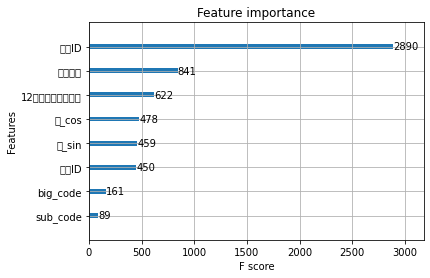

In [ ]:
xgb.plot_importance(xgb_m)
plt.show()

#後処理

In [ ]:
syouhin_ID_list=test['商品ID'].unique()
three_month=[]
for i in syouhin_ID_list:
  for j in range(0,18):
    tmp=sum(all_train[(all_train['商品ID']==i)&(all_train['店舗ID']==j)]['売上個数'].tail(3))
    if tmp==0:
      three_month.append(0)
    else:
      three_month.append(1)
sub['three']=three_month

In [ ]:
sub.head()

,0,1,three
0,0,1.048923,1
1,1,0.789428,0
2,2,0.985302,1
3,3,1.438433,1
4,4,5.168853,1


In [ ]:
sub[1] = sub[1]*sub['three']
sub.head()

,0,1,three
0,0,1.048923,1
1,1,0.000000,0
2,2,0.985302,1
3,3,1.438433,1
4,4,5.168853,1


In [ ]:
sub = sub.drop('three',axis=1)

In [ ]:
print(sub.info())
sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3060 non-null   int64  
 1   1       3060 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 47.9 KB
None


,0,1
0,0,0.600000
1,1,0.000000
2,2,1.933333
3,3,2.500000
4,4,8.733333


In [ ]:
sub.to_csv('submission_xgb6.csv',index=False,header=False)

In [ ]:
sub.iloc[:,-1] = pred
sub.head()

,0,1
0,0,0.871740
1,1,0.447480
2,2,0.730039
3,3,3.015038
4,4,5.447911


In [ ]:
sub.to_csv('submission_lgb6.csv',index=False,header=False)